## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
# Set plots style
plt.style.use('seaborn-v0_8-paper')

## Load Topics Data

In [3]:
topics = pd.read_csv('data/topics_by_minute.csv')
topics = topics[['date', 'channel', 'minute', 'text', 'words_topic']]

# Filter out the 'tve' channel
topics = topics[topics['channel'] != 'tve']
topics.shape

(50124, 5)

In [4]:
# Assuming your dataframe is named df and the date column is named 'date_column'
topics['date'] = pd.to_datetime(topics['date'])

# Filter out observations for May 2024
topics = topics[~((topics['date'].dt.month == 5) & (topics['date'].dt.year == 2024))]
topics.shape

(48940, 5)

In [5]:
# Create the 'ukraine' column
topics['ukraine'] = topics['words_topic'].apply(lambda x: 1 if 'ucrania' in x else 0)

# Extract the month and year from the date column
topics['year_month'] = topics['date'].dt.to_period('M')

In [6]:
# Extract the month and year from the date column
topics['week'] = topics['date'].dt.to_period('W')

In [7]:
topics.date.min(), topics.date.max()

(Timestamp('2022-12-02 00:00:00'), Timestamp('2024-04-30 00:00:00'))

## Share of Time Speaking about the Russia-Ukraine War

In [8]:
# Group by year_month and channel, and count total records and records with 'ukraine' = 1
observations_by_month = topics.groupby(['channel', 'year_month']).agg(
    total_records=('date', 'size'),
    num_with_ukraine=('ukraine', 'sum')
).reset_index()

# Calculate the share of records mentioning 'ukraine'
observations_by_month['share_with_ukraine'] = observations_by_month['num_with_ukraine'] / observations_by_month['total_records']

# Convert 'year_month' to a datetime format
observations_by_month['year_month'] = observations_by_month['year_month'].dt.to_timestamp()

observations_by_month.head()

,channel,year_month,total_records,num_with_ukraine,share_with_ukraine
0,a3,2022-12-01,886,81,0.091422
1,a3,2023-01-01,1039,153,0.147257
2,a3,2023-02-01,935,183,0.195722
3,a3,2023-03-01,1027,115,0.111977
4,a3,2023-04-01,966,88,0.091097


In [9]:
# Group by week and channel, and count total records and records with 'ukraine' = 1
observations_by_week = topics.groupby(['channel', 'week']).agg(
    total_records=('date', 'size'),
    num_with_ukraine=('ukraine', 'sum')
).reset_index()

# Calculate the share of records mentioning 'ukraine'
observations_by_week['share_with_ukraine'] = observations_by_week['num_with_ukraine'] / observations_by_week['total_records']

# Convert 'year_month' to a datetime format
observations_by_week['week'] = observations_by_week['week'].dt.to_timestamp()

observations_by_week.head()

,channel,week,total_records,num_with_ukraine,share_with_ukraine
0,a3,2022-11-28,104,11,0.105769
1,a3,2022-12-05,231,19,0.082251
2,a3,2022-12-12,227,11,0.048458
3,a3,2022-12-19,200,23,0.115000
4,a3,2022-12-26,160,21,0.131250


In [11]:
# Group by year_month and channel, and count total records and records with 'ukraine' = 1
topics_by_day = topics.groupby(['channel', 'date']).agg(
    total_records=('date', 'size'),
    num_with_ukraine=('ukraine', 'sum')
).reset_index()


topics_by_day

,channel,date,total_records,num_with_ukraine
0,a3,2022-12-02,31,3
1,a3,2022-12-03,37,8
2,a3,2022-12-04,36,0
3,a3,2022-12-05,32,5
4,a3,2022-12-06,31,2
...,...,...,...,...
1321,t5,2024-04-25,31,1
1322,t5,2024-04-26,31,2
1323,t5,2024-04-28,31,0
1324,t5,2024-04-29,31,0


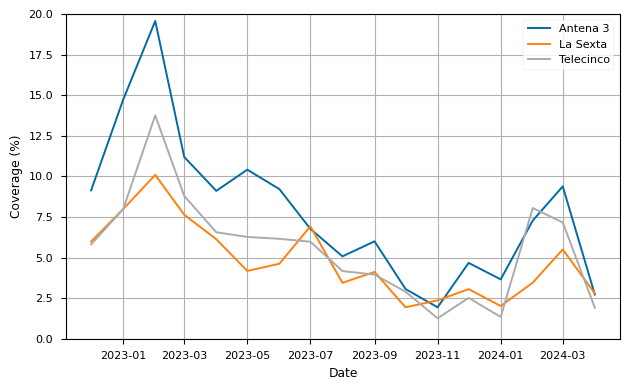

In [86]:
# Plotting
plt.figure(figsize=(6.4, 4))

channels = observations_by_month['channel'].unique()
channel_names = ['Antena 3', 'La Sexta', 'Telecinco']

for channel, channel_name in zip(channels, channel_names):
    channel_data = observations_by_month[observations_by_month['channel'] == channel]
    plt.plot(channel_data['year_month'], channel_data['share_with_ukraine'] * 100, label=channel_name)

#plt.title('Share of Time Speaking about the Russia-Ukraine War')
plt.xlabel('Month')
plt.ylabel('Coverage (%)')
plt.ylim(0, 20)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(
    'report_charts/coverge_time_trend.pdf',
    bbox_inches='tight',
)

plt.show()

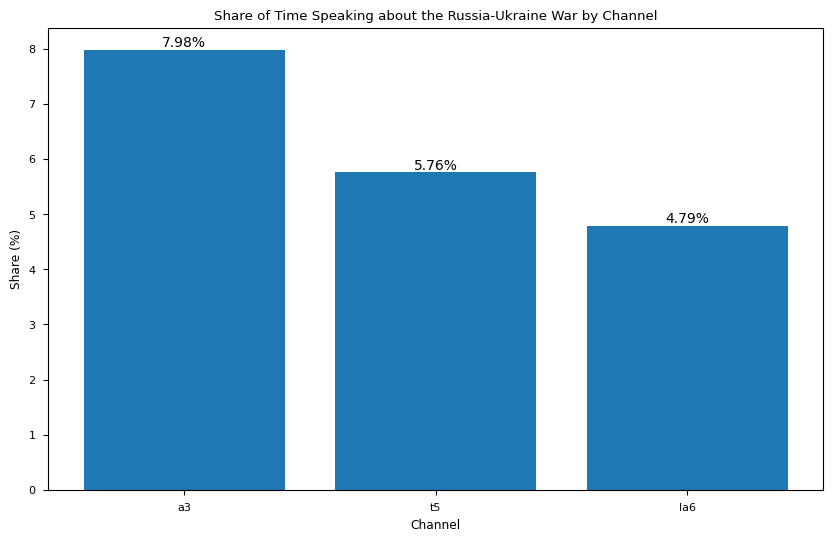

In [12]:
# Group by 'channel' and calculate the total 'total_records' and 'num_with_ukraine'
channel_summary = observations_by_month.groupby('channel').agg({
    'total_records': 'sum',
    'num_with_ukraine': 'sum'
}).reset_index()

# Calculate 'share_with_ukraine'
channel_summary['share_with_ukraine'] = channel_summary['num_with_ukraine'] / channel_summary['total_records']

# Sort the DataFrame by 'share_with_ukraine' in descending order
channel_summary = channel_summary.sort_values(by='share_with_ukraine', ascending=False)

# Convert 'share_with_ukraine' to percentages
channel_summary['share_with_ukraine'] = channel_summary['share_with_ukraine'] * 100

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(channel_summary['channel'], channel_summary['share_with_ukraine'])

# Add labels and title
plt.xlabel('Channel')
plt.ylabel('Share (%)')
plt.title('Share of Time Speaking about the Russia-Ukraine War by Channel')

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}%',
        ha='center',
        va='bottom'
    )

# Display the plot
plt.show()

## Restructure Topics Data for Future Use

In [13]:
# Convert 'year_month' to datetime format
observations_by_month['year_month'] = pd.to_datetime(observations_by_month['year_month'])

# Group by 'year_month' and aggregate
df_restructured = observations_by_month.groupby('year_month').agg(
    total_records=('total_records', 'sum'),
    num_with_ukraine=('num_with_ukraine', 'sum')
).reset_index()

# Calculate 'share_with_ukraine'
df_restructured['share_with_ukraine'] = df_restructured['num_with_ukraine'] / df_restructured['total_records']

# Sort by 'year_month'
df_restructured = df_restructured.sort_values(by='year_month')

# Make sure observations_by_month is also sorted
observations_by_month = observations_by_month.sort_values(by=['channel', 'year_month'])

# Add shares for each channel as a separate column
df_restructured['a3_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 'a3'].reset_index()['share_with_ukraine']
df_restructured['la6_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 'la6'].reset_index()['share_with_ukraine']
df_restructured['t5_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 't5'].reset_index()['share_with_ukraine']
df_restructured.head()

,year_month,total_records,num_with_ukraine,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-12-01,2962,204,0.068872,0.091422,0.059908,0.058140
1,2023-01-01,3155,322,0.102060,0.147257,0.079872,0.079861
2,2023-02-01,2989,422,0.141184,0.195722,0.100925,0.137572
3,2023-03-01,3224,293,0.090881,0.111977,0.076399,0.088000
4,2023-04-01,2963,214,0.072224,0.091097,0.061329,0.065614


In [14]:
# Convert 'year_month' to datetime format
observations_by_week['week'] = pd.to_datetime(observations_by_week['week'])

# Group by 'year_month' and aggregate
df_restructured_weekly = observations_by_week.groupby('week').agg(
    total_records=('total_records', 'sum'),
    num_with_ukraine=('num_with_ukraine', 'sum')
).reset_index()

# Calculate 'share_with_ukraine'
df_restructured_weekly['share_with_ukraine'] = df_restructured_weekly['num_with_ukraine'] / df_restructured_weekly['total_records']

# Sort by 'year_month'
df_restructured_weekly = df_restructured_weekly.sort_values(by='week')

# Make sure observations_by_month is also sorted
observations_by_week = observations_by_week.sort_values(by=['channel', 'week'])

# Add shares for each channel as a separate column
df_restructured_weekly['a3_share_with_ukraine'] = observations_by_week[observations_by_week.channel == 'a3'].reset_index()['share_with_ukraine']
df_restructured_weekly['la6_share_with_ukraine'] = observations_by_week[observations_by_week.channel == 'la6'].reset_index()['share_with_ukraine']
df_restructured_weekly['t5_share_with_ukraine'] = observations_by_week[observations_by_week.channel == 't5'].reset_index()['share_with_ukraine']
df_restructured_weekly.head()

,week,total_records,num_with_ukraine,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-11-28,316,22,0.069620,0.105769,0.053030,0.050000
1,2022-12-05,751,62,0.082557,0.082251,0.081761,0.084158
2,2022-12-12,724,28,0.038674,0.048458,0.046429,0.018433
3,2022-12-19,620,55,0.088710,0.115000,0.072581,0.081395
4,2022-12-26,667,52,0.077961,0.131250,0.051351,0.087591


## Explore Missing Data

### Number of Missing Videos

(out of those present in the topics file, the Russia-Ukraine War topic only)

In [18]:
folder = '/Users/viktoriia/Desktop/thesis/data/frames'
subfolders = ['atres', 'la6', 'telecinco', 'tve']

# Dictionary to store the list of files for each subfolder
files_in_subfolders = {}

# Iterate through each subfolder and get the list of files
for subfolder in subfolders:
    subfolder_path = os.path.join(folder, subfolder)
    # List all files in the subfolder
    files = os.listdir(subfolder_path)
    files_in_subfolders[subfolder] = files

atres_files = files_in_subfolders['atres']
la6_files = files_in_subfolders['la6']
telecinco_files = files_in_subfolders['telecinco']

# Function to filter files that end with .jpg
def filter_jpg_files(file_list):
    if file_list is not None:
        return [file for file in file_list if file.endswith('.jpg')]
    return []

# Filter .jpg files in each subfolder
atres_files_jpg = filter_jpg_files(files_in_subfolders['atres'])
la6_files_jpg = filter_jpg_files(files_in_subfolders['la6'])
telecinco_files_jpg = filter_jpg_files(files_in_subfolders['telecinco'])
tve_files_jpg = filter_jpg_files(files_in_subfolders['tve'])

print(len(atres_files_jpg))
print(len(la6_files_jpg))
print(len(telecinco_files_jpg))

48038
57928
46236


In [19]:
atres_dates = list(set([name.split('_')[3] for name in atres_files_jpg]))
la6_dates = list(set([name.split('_')[3] for name in la6_files_jpg]))
t5_dates = list(set([name.split('_')[3] for name in telecinco_files_jpg]))

# Num of unique dates in the folder
len(atres_dates), len(la6_dates), len(t5_dates)

(304, 310, 294)

In [20]:
# Filter the DataFrame
topics_ua = topics[topics['words_topic'].apply(lambda x: 'ucrania' in x)]
print(topics_ua.shape)

a3_df = topics_ua[topics_ua.channel == 'a3']
la6_df = topics_ua[topics_ua.channel == 'la6']
t5_df = topics_ua[topics_ua.channel == 't5']

a3_dates_topics = a3_df.date.unique()
la6_dates_topics = la6_df.date.unique()
t5_dates_topics = t5_df.date.unique()

# Num of unique dates in the topics file
len(a3_dates_topics), len(la6_dates_topics), len(t5_dates_topics)

(2964, 8)


(393, 318, 281)

In [21]:
# Convert string dates to datetime
atres_dates_dt = pd.to_datetime(atres_dates)
la6_dates_dt = pd.to_datetime(la6_dates)
t5_dates_dt = pd.to_datetime(t5_dates)

# Find dates in a3_dates_topics not in atres_dates_dt
a3_diff = [date for date in a3_dates_topics if date not in atres_dates_dt]

# Find dates in la6_dates_topics not in la6_dates_dt
la6_diff = [date for date in la6_dates_topics if date not in la6_dates_dt]

# Find dates in t5_dates_topics not in t5_dates_dt
t5_diff = [date for date in t5_dates_topics if date not in t5_dates_dt]

len(a3_diff), len(la6_diff), len(t5_diff)

(104, 8, 0)

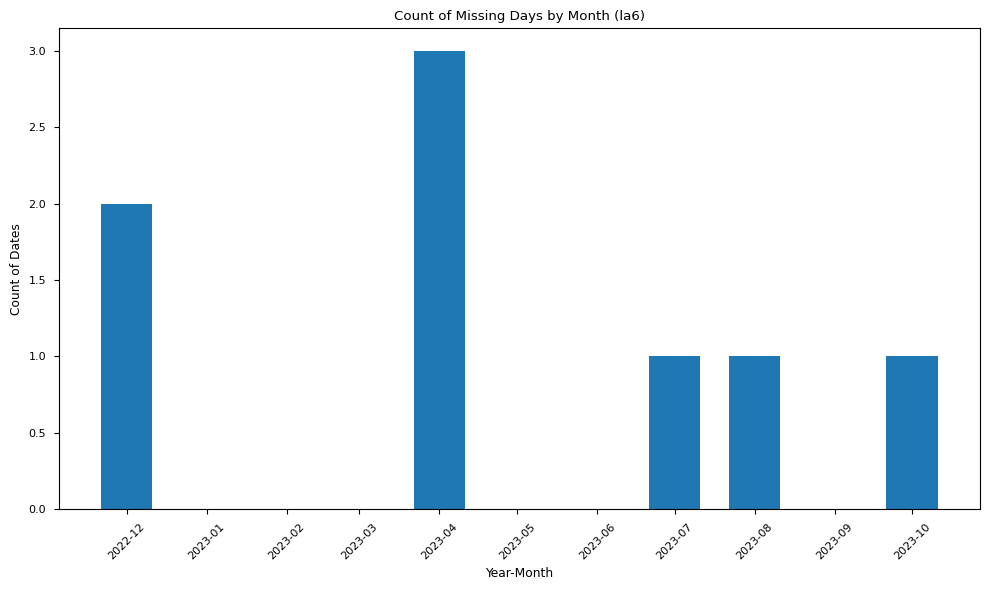

In [22]:
# Convert the list to a DataFrame
la6_df = pd.DataFrame(la6_diff, columns=['date'])

# Extract year and month
la6_df['year_month'] = la6_df['date'].dt.to_period('M')

# Group by year and month and count the occurrences
la6_missing_by_month = la6_df['year_month'].value_counts().sort_index()

# Convert the list to a DataFrame
la6_df = pd.DataFrame(la6_diff, columns=['date'])

# Extract year and month
la6_df['year_month'] = la6_df['date'].dt.to_period('M')

# Convert the Series to a DataFrame
la6_missing_by_month = la6_missing_by_month.reset_index()
la6_missing_by_month.columns = ['year_month', 'count']

# Convert 'year_month' to timestamp for plotting
la6_missing_by_month['year_month'] = la6_missing_by_month['year_month'].dt.to_timestamp()

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(la6_missing_by_month['year_month'], la6_missing_by_month['count'], width=20)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Count of Dates')
plt.title('Count of Missing Days by Month (la6)')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

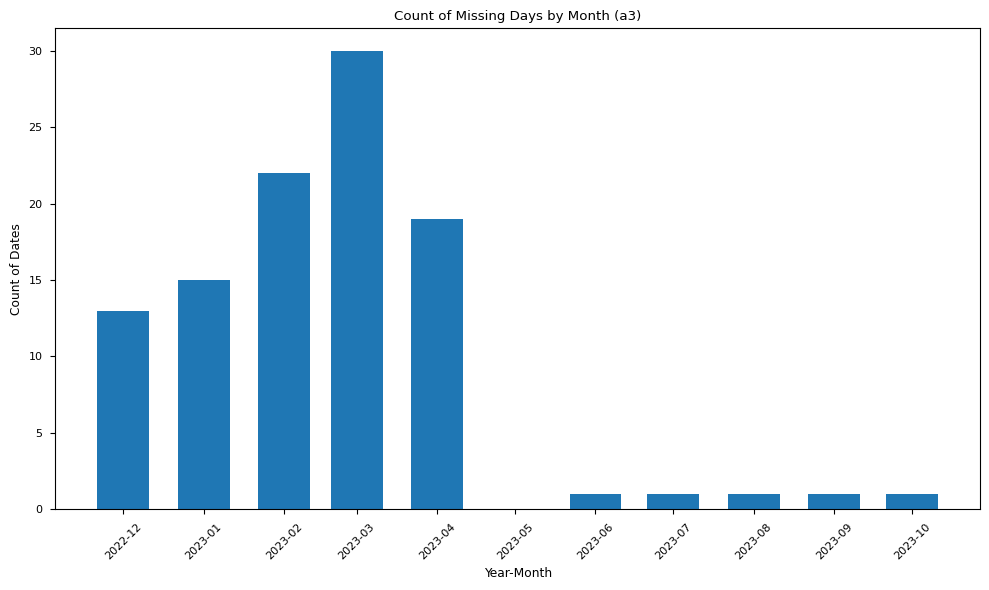

In [23]:
# Convert the list to a DataFrame
a3_df = pd.DataFrame(a3_diff, columns=['date'])

# Extract year and month
a3_df['year_month'] = a3_df['date'].dt.to_period('M')

# Group by year and month and count the occurrences
a3_missing_by_month = a3_df['year_month'].value_counts().sort_index()

# Convert the list to a DataFrame
a3_df = pd.DataFrame(a3_diff, columns=['date'])

# Extract year and month
a3_df['year_month'] = a3_df['date'].dt.to_period('M')

# Convert the Series to a DataFrame
a3_missing_by_month = a3_missing_by_month.reset_index()
a3_missing_by_month.columns = ['year_month', 'count']

# Convert 'year_month' to timestamp for plotting
a3_missing_by_month['year_month'] = a3_missing_by_month['year_month'].dt.to_timestamp()

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(a3_missing_by_month['year_month'], a3_missing_by_month['count'], width=20)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Count of Dates')
plt.title('Count of Missing Days by Month (a3)')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Total number of missing days

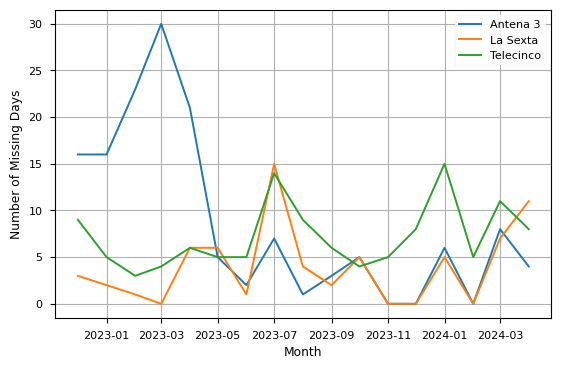

In [28]:
import calendar

a3_missing_by_month['channel'] = 'a3'
la6_missing_by_month['channel'] = 'la6'

missing_videos = pd.concat([a3_missing_by_month, la6_missing_by_month])

# Group by 'channel' and 'year_month' and count unique days
grouped = topics.groupby(['channel', 'year_month'])['date'].nunique().reset_index()
grouped = grouped.rename(columns={'date': 'unique_days'})

# Calculate the number of days in each month
grouped['days_in_month'] = grouped['year_month'].apply(lambda x: calendar.monthrange(x.year, x.month)[1])

# Calculate missing days
grouped['missing_days'] = grouped['days_in_month'] - grouped['unique_days']

# Convert 'year_month' to timestamp for plotting
grouped['year_month'] = grouped['year_month'].dt.to_timestamp()


grouped = pd.merge(grouped, missing_videos, on=['year_month', 'channel'], how='left')
# Replace NaNs in the 'count' column with 0
grouped['count'] = grouped['count'].fillna(0)
grouped['missing_days_count'] = grouped['missing_days'] + grouped['count']

# Mapping for channel labels
channel_labels = {
    'a3': 'Antena 3',
    'la6': 'La Sexta',
    't5': 'Telecinco'
}

# Plotting
plt.figure(figsize=(6.4, 4))

for channel in grouped['channel'].unique():
    channel_data = grouped[grouped['channel'] == channel]
    plt.plot(channel_data['year_month'], channel_data['missing_days_count'], label=channel_labels[channel])

#     .dt.strftime('%Y-%m')
    
# Adding labels and title
plt.ylabel('Number of Missing Days')
plt.xlabel('Month')
plt.legend()
plt.grid(True)
# plt.xticks(rotation=45)

# Saving plot
plt.savefig('report_charts/MissingData.pdf', bbox_inches='tight')

# Displaying the plot
plt.show()

## Load Additional Data

### Massive Missile Attacks on Ukraine

In [29]:
# Load data
df_missiles_daily = pd.read_csv('additional_data/missile_attacks/missile_attacks_daily.csv')
df_missiles_description = pd.read_csv('additional_data/missile_attacks/missiles_and_uav.csv')
df_missiles = df_missiles_daily.merge(df_missiles_description, how='left', on=['model'])
print(df_missiles.shape)
display(df_missiles)

(1167, 21)


,time_start,time_end,model,launch_place,target,destroyed_details,carrier,launched,destroyed,source,...,national_origin,type,launch_platform,name,name_NATO,guidance_system,features,unit_cost,produced,manufacturer
0,2024-06-08,2024-06-08 08:00,X-59,Kursk oblast,east,NaN,NaN,1.0,1,kpszsu/posts/pfbid0ura4yLKn4kKnbnW6WeNqaTWiasN...,...,russia,air-to-surface,"Su-30MK, Su-24M, MiG-27, Su-17M3/22M4, HAL Tej...",Kh-59 Ovod,AS-13 'Kingbolt',NaN,NaN,NaN,NaN,NaN
1,2024-06-08,2024-06-08 08:00,Supercam,NaN,east,NaN,NaN,2.0,2,pvkshid/posts/pfbid02x9v3uZxSB3TgdedK5kF7DyNPN...,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmanned Systems Group
2,2024-06-08,2024-06-08 08:00,Shahed-136/131,"Chauda, Crimea and Kursk oblast",Ukraine,"{'Poltava oblast': 1, 'Kharkiv oblast': NaN, '...",NaN,13.0,9,kpszsu/posts/pfbid0ura4yLKn4kKnbnW6WeNqaTWiasN...,...,iran,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shahed Aviation Industries
3,2024-06-08,2024-06-08,Lancet,NaN,Kherson oblast,NaN,NaN,4.0,4,PvKPivden/posts/pfbid02GLn4kq7vQfjLQD4vaKycwQD...,...,russia,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZALA Aero Group
4,2024-06-07,2024-06-07 08:00,X-101/X-555,Saratov oblast,west,NaN,Tu-95MS,5.0,5,kpszsu/posts/pfbid0zAYzn1GoGTtWFRi283Z8pnCJKZJ...,...,russia,air-launched,"Tu-95MS, Tu-160, Su-34",Kh-101/Kh-555,Kent-C,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,2022-10-01 12:00,2022-10-01 12:00,Orlan-10,NaN,Ukraine,NaN,NaN,1.0,1,watch/?v=375517448001233,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Special Technology Center
1163,2022-09-30,2022-09-30,Orlan-10,NaN,Ukraine,NaN,NaN,3.0,3,kpszsu/posts/pfbid0nELeXY4BpHrezv54Lk3gWPZJmcC...,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Special Technology Center
1164,2022-09-29 23:00,2022-09-29 23:59,Shahed-136/131,NaN,Odesa oblast and Mykolaiv oblast,NaN,NaN,7.0,5,kpszsu/posts/pfbid021aK2TqryAuB8gGrDYMTv3R8Xiu...,...,iran,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shahed Aviation Industries
1165,2022-09-28,2022-09-28,X-59,NaN,Dnipropetrovsk oblast and Zaporizhzhia oblast,NaN,Su-35,5.0,4,kpszsu/posts/pfbid02sjn5m7kosAfsm5bSUzpPwbLuH3...,...,russia,air-to-surface,"Su-30MK, Su-24M, MiG-27, Su-17M3/22M4, HAL Tej...",Kh-59 Ovod,AS-13 'Kingbolt',NaN,NaN,NaN,NaN,NaN


In [30]:
# Convert 'time_start' to datetime format using the mixed format
df_missiles['time_start'] = pd.to_datetime(df_missiles['time_start'], format='mixed')

# Extract month and year
df_missiles['year_month'] = df_missiles['time_start'].dt.to_period('M')
df_missiles['week'] = df_missiles['time_start'].dt.to_period('W')

# Group by month and year and sum 'launched'
df_aggregated = df_missiles.groupby('year_month')['launched'].sum().reset_index()

# Convert 'month_year' back to a datetime format for easier reading (optional)
df_aggregated['year_month'] = df_aggregated['year_month'].dt.to_timestamp()

# Rename columns for clarity
# df_aggregated.columns = ['Month', 'Total_Launched']

# Filter the DataFrame to include only months from 2022-12 to 2024-04
start_date = pd.Timestamp('2022-12-01')
end_date = pd.Timestamp('2024-04-30')
df_aggregated = df_aggregated[(df_aggregated['year_month'] >= start_date) & (df_aggregated['year_month'] <= end_date)]

In [31]:
df_aggregated_weekly = df_missiles.groupby('week')['launched'].sum().reset_index()
# Convert 'week' back to a datetime format for easier reading (optional)
df_aggregated_weekly['week'] = df_aggregated_weekly['week'].dt.to_timestamp()

# Filter the DataFrame to include only months from 2022-12 to 2024-04
start_date = pd.Timestamp('2022-12-01')
end_date = pd.Timestamp('2024-04-30')
df_aggregated_weekly = df_aggregated_weekly[(df_aggregated_weekly['week'] >= start_date) & (df_aggregated_weekly['week'] <= end_date)]

In [32]:
# Merge df_aggregated with df_restructured on 'Month' and 'year_month'
df_aggregated = pd.merge(df_aggregated, df_restructured[['year_month', 
                                                         'share_with_ukraine',
                                                        'a3_share_with_ukraine',
                                                        'la6_share_with_ukraine',
                                                        't5_share_with_ukraine']], on='year_month', how='left')
df_aggregated.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614


In [33]:
# Merge df_aggregated with df_restructured on 'Month' and 'week'
df_aggregated_weekly = pd.merge(df_aggregated_weekly, df_restructured_weekly[['week', 
                                                         'share_with_ukraine',
                                                        'a3_share_with_ukraine',
                                                        'la6_share_with_ukraine',
                                                        't5_share_with_ukraine']], on='week', how='left')
df_aggregated_weekly.head()

,week,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-12-05,99.0,0.082557,0.082251,0.081761,0.084158
1,2022-12-12,116.0,0.038674,0.048458,0.046429,0.018433
2,2022-12-19,38.0,0.088710,0.115000,0.072581,0.081395
3,2022-12-26,156.0,0.077961,0.131250,0.051351,0.087591
4,2023-01-02,41.0,0.076590,0.074257,0.088123,0.065502


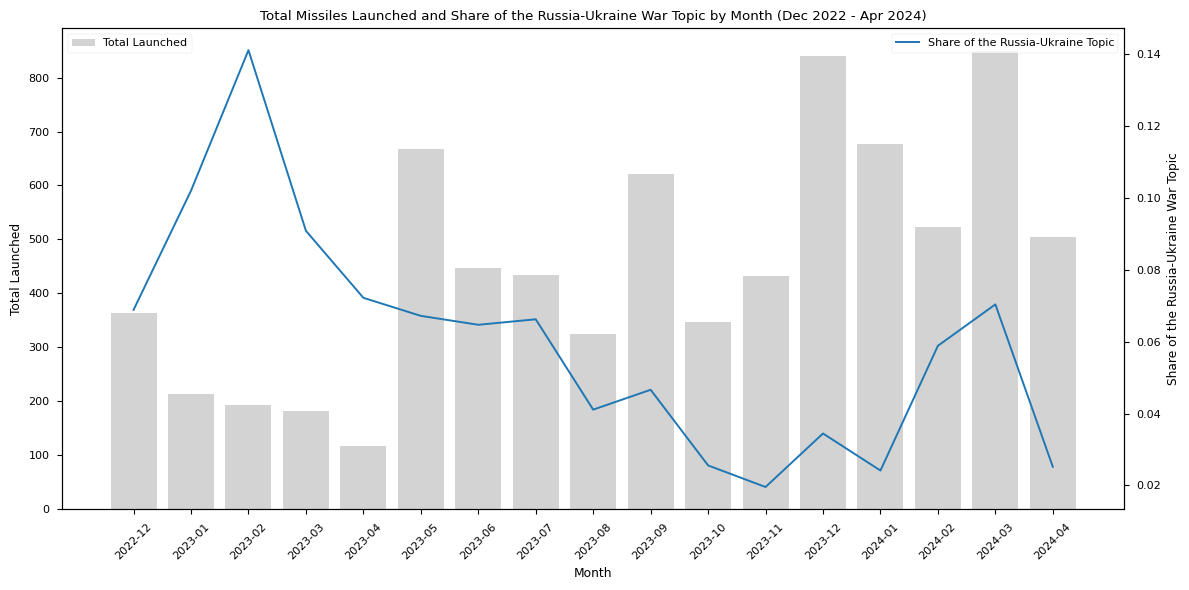

In [34]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['launched'], color='lightgrey', label='Total Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['share_with_ukraine'], label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

### Number of Fatalities

In [35]:
fatalities = pd.read_csv('additional_data/number_of_fatalities/2022-12-01-2024-05-13-Europe-Ukraine.csv')
fatalities.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,UKR158104,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Zmiyinyy Island,45.2549,30.2037,1,Institute for the Study of War,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715125698
1,UKR158083,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Baranivka,51.9219,34.1846,2,Ministry of Defence of Ukraine; Suspilne Media,Other-National,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
2,UKR158084,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Bohoiavlenka,47.8601,37.2135,2,Ministry of Defence of Ukraine,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
3,UKR158085,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Borova,49.3777,37.6214,2,Ministry of Defence of Ukraine,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
4,UKR158086,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Chasiv Yar,48.5869,37.8324,1,Novoye Vremya Ukraine; Suspilne Media,National,"On 3 May 2024, Russian Forces launched FPV-dro...",1,NaN,1715131178


In [36]:
# Convert 'event_date' to datetime format (adjusting format to handle full month names)
fatalities['event_date'] = pd.to_datetime(fatalities['event_date'], format="%d %B %Y")

# Filter to include only months from December 2022 to April 2024
start_date = pd.Timestamp('2022-12-01')
end_date = pd.Timestamp('2024-04-30')
fatalities_filtered = fatalities[(fatalities['event_date'] >= start_date) & (fatalities['event_date'] <= end_date)]

# Group by month and sum the fatalities
fatalities_filtered['year_month'] = fatalities_filtered['event_date'].dt.to_period('M')
fatalities_filtered['week'] = fatalities_filtered['event_date'].dt.to_period('W')

fatalities_by_month = fatalities_filtered.groupby('year_month')['fatalities'].sum().reset_index()
fatalities_by_week = fatalities_filtered.groupby('week')['fatalities'].sum().reset_index()

# Convert 'month_year' back to a datetime format for easier reading (optional)
fatalities_by_month['year_month'] = fatalities_by_month['year_month'].dt.to_timestamp()
fatalities_by_week['week'] = fatalities_by_week['week'].dt.to_timestamp()

/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_51917/2348508956.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatalities_filtered['year_month'] = fatalities_filtered['event_date'].dt.to_period('M')
/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_51917/2348508956.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatalities_filtered['week'] = fatalities_filtered['event_date'].dt.to_period('W')


In [37]:
# Merge df_aggregated with df_restructured on 'Month' and 'year_month'
df_aggregated = pd.merge(df_aggregated, fatalities_by_month, on='year_month', how='left')
df_aggregated.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140,2174
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861,1187
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572,665
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000,866
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614,1135


In [38]:
# Merge df_aggregated with df_restructured on 'Month' and 'year_month'
df_aggregated_weekly = pd.merge(df_aggregated_weekly, fatalities_by_week, on='week', how='left')
df_aggregated_weekly.head()

,week,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities
0,2022-12-05,99.0,0.082557,0.082251,0.081761,0.084158,313
1,2022-12-12,116.0,0.038674,0.048458,0.046429,0.018433,282
2,2022-12-19,38.0,0.088710,0.115000,0.072581,0.081395,646
3,2022-12-26,156.0,0.077961,0.131250,0.051351,0.087591,972
4,2023-01-02,41.0,0.076590,0.074257,0.088123,0.065502,211


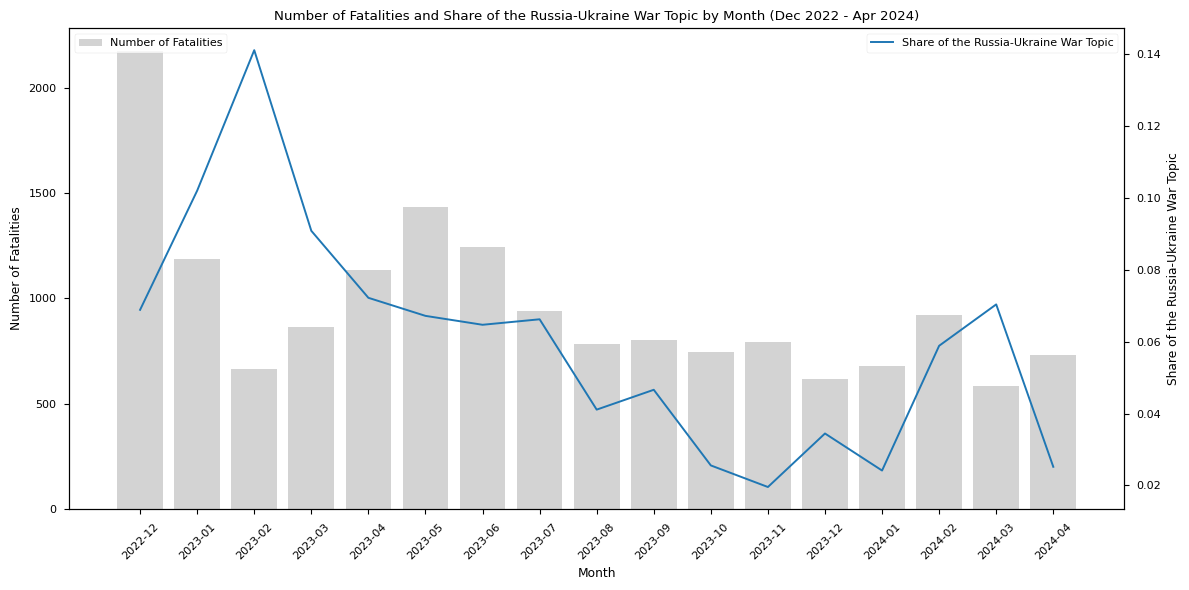

In [39]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['fatalities'], color='lightgrey', label='Number of Fatalities')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Fatalities')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['share_with_ukraine'],  label='Share of the Russia-Ukraine War Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')
ax2.legend(loc='upper right')

plt.title('Number of Fatalities and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

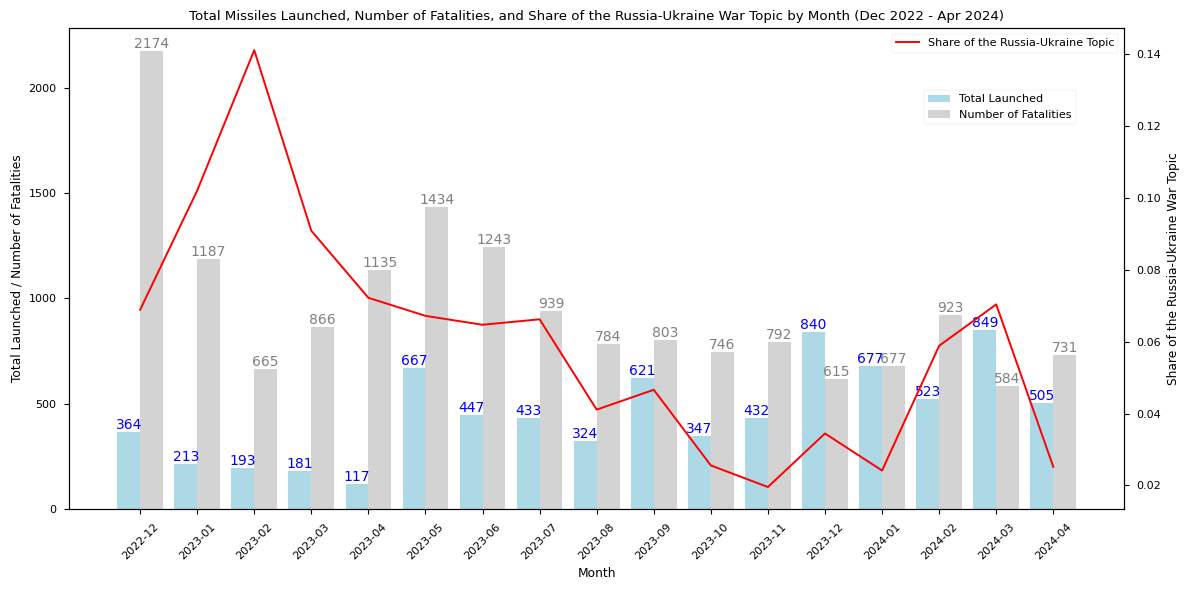

In [40]:
# Plotting missiles launched and fatalities together with share of war coverage

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Plot the second bar chart (Number of Fatalities)
bars2 = ax1.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched / Number of Fatalities')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine'], color='r', label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.81, 0.8))
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()


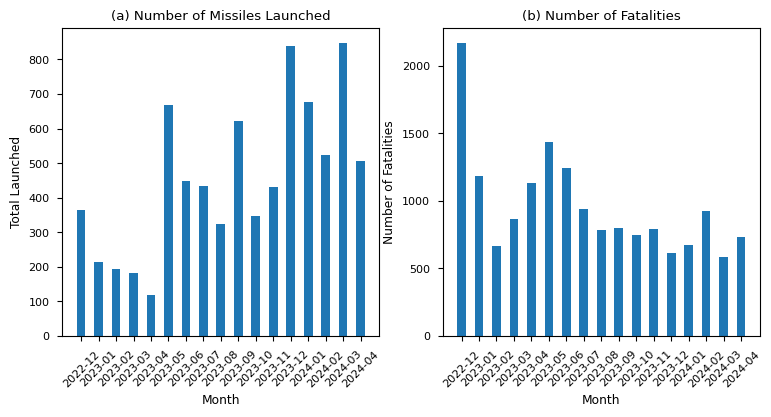

In [41]:
df_aggregated['year_month'] = pd.to_datetime(df_aggregated['year_month'])

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.5

# Positions of the bars on the x-axis
r1 = np.arange(n)

# Plotting the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))  # 1 row, 2 columns for two subplots

# Plot the first bar chart (Total Launched) on ax1
bars1 = ax1.bar(r1, df_aggregated['launched'], width=bar_width, label='Total Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.set_xticks(r1)
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)
ax1.set_title('(a) Number of Missiles Launched')

# Plot the second bar chart (Number of Fatalities) on ax2
bars2 = ax2.bar(r1, df_aggregated['fatalities'], width=bar_width, label='Number of Fatalities')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Fatalities')
ax2.set_xticks(r1)
ax2.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)
ax2.set_title('(b) Number of Fatalities')

plt.savefig('report_charts/missiles_and_fatalities.pdf', bbox_inches='tight')

plt.show()

## Predictions on Entire Dataset

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import torchvision
# import numpy as np
# from typing import List
# import os
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# from torchvision.io import read_image
# from torchvision import transforms, models
# from torch.utils.data import random_split
# from torchvision.transforms.functional import to_pil_image
# import torch.optim as optim
# from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# from tqdm import tqdm
# import torch.nn.functional as F

In [21]:
# resnet50 = torchvision.models.resnet50(weights=("pretrained", models.ResNet50_Weights.IMAGENET1K_V1))

# # Freeze all the parameters
# for param in resnet50.parameters():
#     param.requires_grad = False

# # Replace the final fully connected layer
# num_ftrs = resnet50.fc.in_features
# # Define the custom head with two additional dense layers
# resnet50.fc = torch.nn.Sequential(
#     torch.nn.Linear(num_ftrs, 512),
#     torch.nn.ReLU(),
#     # torch.nn.Dropout(0.5),  # Optional dropout for regularization
#     torch.nn.Linear(512, 256),
#     torch.nn.ReLU(),
#     # torch.nn.Dropout(0.5),  # Optional dropout for regularization
#     torch.nn.Linear(256, 1)
# )

# # Move the model to the GPU if available
# device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# resnet50 = resnet50.to(device)

In [22]:
# # Load the weights
# saved_weights_path = '/Users/viktoriia/Desktop/thesis/pytorch/model_weights/resnet50_TL-L4.pth'
# resnet50.load_state_dict(torch.load(saved_weights_path, map_location=device))

In [23]:
# class UnlabeledImageDataset(torch.utils.data.Dataset):
#     def __init__(self, img_dir, transform=None):
#         self.img_dir = img_dir
#         # self.img_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]
#         self.img_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir) if img.lower().endswith(('jpeg', 'jpg', 'png', 'gif'))]
#         self.transform = transform

#     def __len__(self):
#         return len(self.img_paths)

#     def __getitem__(self, idx):
#         img_path = self.img_paths[idx]
#         image = read_image(img_path)
        
#         # Convert tensor to PIL image
#         image = to_pil_image(image)

#         if self.transform:
#             image = self.transform(image)

#         return image, img_path  # Return image and its path


# # Use same transformations as before
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
# ])

In [24]:
# # Create data loader
# img_dir = '/Users/viktoriia/Desktop/thesis/data/frames/la6'
# unlabeled_dataset = UnlabeledImageDataset(img_dir, transform=transform)
# unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

In [25]:
# def predict_unlabeled_images(model, dataloader):
#     model.eval()
#     all_probs = []
#     all_img_paths = []

#     with torch.no_grad():  # Disable gradient calculation for evaluation
#         for inputs, img_paths in tqdm(dataloader, desc="Predicting", unit="batch"):
#             inputs = inputs.to(device)
            
#             outputs = model(inputs)
#             probs = torch.sigmoid(outputs)
            
#             all_probs.extend(probs)
#             all_img_paths.extend(img_paths)
    
#     return all_img_paths, all_probs

In [26]:
# # Make predictions
# img_paths, predictions = predict_unlabeled_images(resnet50, unlabeled_dataloader)

In [27]:
# # Convert the list of tensors to a list of floats
# predictions = [pred.item() for pred in predictions]

# threshold = 0.6
# binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

# # Create a DataFrame
# df = pd.DataFrame({
#     'filename': img_paths,
#     'predicted_class': binary_predictions
# })

# #TODO: convert to a dataframe
# df['date'] = df['filename'].apply(lambda x: x.split('_')[3])

In [28]:
# # Step 1: Convert the 'date' column to datetime format
# df['date'] = pd.to_datetime(df['date'])

# # Step 2: Extract month and year
# df['year_month'] = df['date'].dt.to_period('M')

# # Group by year-month and calculate the share of class 1.0 observations
# share_class_1 = df.groupby('year_month')['predicted_class'].mean().reset_index()
# share_class_1

# # Rename the column for better clarity
# share_class_1 = share_class_1.rename(columns={'predicted_class': 'la6_share_class_1'})

# # Convert 'month_year' back to a datetime format for easier reading (optional)
# share_class_1['year_month'] = share_class_1['year_month'].dt.to_timestamp()

In [29]:
# df.to_csv('./la6_predictions.csv', index=False)
# share_class_1.to_csv('./la6_predictions_agg.csv', index=False)

In [42]:
# Load Predictions

a3_predictions = pd.read_csv('predictions/a3_bias_corrected.csv')
a3_predictions['channel'] = 'a3'

la6_predictions = pd.read_csv('predictions/la6_bias_corrected.csv')
la6_predictions['channel'] = 'la6'

t5_predictions = pd.read_csv('predictions/t5_bias_corrected.csv')
t5_predictions['channel'] = 't5'

# Convert the 'date' column to datetime format
a3_predictions['date'] = pd.to_datetime(a3_predictions['date'])
la6_predictions['date'] = pd.to_datetime(la6_predictions['date'])
t5_predictions['date'] = pd.to_datetime(t5_predictions['date'])

# Extract month and year
a3_predictions['year_month'] = a3_predictions['date'].dt.to_period('M')
la6_predictions['year_month'] = la6_predictions['date'].dt.to_period('M')
t5_predictions['year_month'] = t5_predictions['date'].dt.to_period('M')

a3_predictions['week'] = a3_predictions['date'].dt.to_period('W')
la6_predictions['week'] = la6_predictions['date'].dt.to_period('W')
t5_predictions['week'] = t5_predictions['date'].dt.to_period('W')

combined_predictions = pd.concat([a3_predictions, la6_predictions, t5_predictions])

In [43]:
combined_predictions.head()

,filename,predicted_class,date,year_month,corrected_preds,channel,week
0,/Users/viktoriia/Desktop/thesis/data/frames/at...,0,2024-05-16,2024-05,0,a3,2024-05-13/2024-05-19
1,/Users/viktoriia/Desktop/thesis/data/frames/at...,1,2023-08-03,2023-08,1,a3,2023-07-31/2023-08-06
2,/Users/viktoriia/Desktop/thesis/data/frames/at...,0,2023-09-08,2023-09,0,a3,2023-09-04/2023-09-10
3,/Users/viktoriia/Desktop/thesis/data/frames/at...,0,2022-12-26,2022-12,0,a3,2022-12-26/2023-01-01
4,/Users/viktoriia/Desktop/thesis/data/frames/at...,0,2024-04-05,2024-04,0,a3,2024-04-01/2024-04-07


#### Get the share of Russia-Ukraine war images out of all images (not just related to the war)

In [44]:
# Grouping by day first so that we can filter out days with missing data
combined_predictions_by_day = combined_predictions.groupby(['channel', 'date']).agg(
    count_class_one=('corrected_preds', 'sum')
).reset_index()

df_aggregated_daily = pd.merge(topics_by_day, combined_predictions_by_day, on=['channel', 'date'], how='left')

# Set count_class_one to 0 where num_with_ukraine is 0 (keep days when they don't speak about Ukraine, share = 0)
df_aggregated_daily.loc[df_aggregated_daily['num_with_ukraine'] == 0, 'count_class_one'] = 0

# Remove days when there is missing data (no video for that day)
df_aggregated_daily = df_aggregated_daily[~df_aggregated_daily.count_class_one.isna()]

# Convert total time from min to sec
df_aggregated_daily['total_seconds'] = df_aggregated_daily['total_records']*60

df_aggregated_daily['year_month'] = df_aggregated_daily['date'].dt.to_period('M')
df_aggregated_daily['week'] = df_aggregated_daily['date'].dt.to_period('W')


### MONTHLY
war_out_of_total_monthly = df_aggregated_daily.groupby(['channel', 'year_month']).agg(
    count_class_one=('count_class_one', 'sum'),
    total_seconds=('total_seconds', 'sum')
).reset_index()

war_out_of_total_monthly['war_share_out_of_total'] = war_out_of_total_monthly['count_class_one']/war_out_of_total_monthly['total_seconds']

# Convert 'year_month' to a datetime format
war_out_of_total_monthly['year_month'] = war_out_of_total_monthly['year_month'].dt.to_timestamp()

a3_war_out_of_total_monthly = war_out_of_total_monthly[war_out_of_total_monthly.channel == 'a3'][['year_month', 'war_share_out_of_total']]
la6_war_out_of_total_monthly = war_out_of_total_monthly[war_out_of_total_monthly.channel == 'la6'][['year_month', 'war_share_out_of_total']]
t5_war_out_of_total_monthly = war_out_of_total_monthly[war_out_of_total_monthly.channel == 't5'][['year_month', 'war_share_out_of_total']]

combined_war_out_of_total_monthly = df_aggregated_daily.groupby(['year_month']).agg(
    count_class_one=('count_class_one', 'sum'),
    total_seconds=('total_seconds', 'sum')
).reset_index()

# Convert 'year_month' to a datetime format
combined_war_out_of_total_monthly['year_month'] = combined_war_out_of_total_monthly['year_month'].dt.to_timestamp()
combined_war_out_of_total_monthly['war_share_out_of_total'] = combined_war_out_of_total_monthly['count_class_one']/combined_war_out_of_total_monthly['total_seconds']
combined_war_out_of_total_monthly = combined_war_out_of_total_monthly[['year_month', 'war_share_out_of_total']]


a3_war_out_of_total_monthly = a3_war_out_of_total_monthly.rename(columns={'war_share_out_of_total': 'a3_war_share_out_of_total'})
la6_war_out_of_total_monthly = la6_war_out_of_total_monthly.rename(columns={'war_share_out_of_total': 'la6_war_share_out_of_total'})
t5_war_out_of_total_monthly = t5_war_out_of_total_monthly.rename(columns={'war_share_out_of_total': 't5_war_share_out_of_total'})
combined_war_out_of_total_monthly = combined_war_out_of_total_monthly.rename(columns={'war_share_out_of_total': 'combined_war_share_out_of_total'})

### WEEKLY
war_out_of_total_weekly = df_aggregated_daily.groupby(['channel', 'week']).agg(
    count_class_one=('count_class_one', 'sum'),
    total_seconds=('total_seconds', 'sum')
).reset_index()

war_out_of_total_weekly['war_share_out_of_total'] = war_out_of_total_weekly['count_class_one']/war_out_of_total_weekly['total_seconds']

# Convert 'year_month' to a datetime format
war_out_of_total_weekly['week'] = war_out_of_total_weekly['week'].dt.to_timestamp()

a3_war_out_of_total_weekly = war_out_of_total_weekly[war_out_of_total_weekly.channel == 'a3'][['week', 'war_share_out_of_total']]
la6_war_out_of_total_weekly = war_out_of_total_weekly[war_out_of_total_weekly.channel == 'la6'][['week', 'war_share_out_of_total']]
t5_war_out_of_total_weekly = war_out_of_total_weekly[war_out_of_total_weekly.channel == 't5'][['week', 'war_share_out_of_total']]

combined_war_out_of_total_weekly = df_aggregated_daily.groupby(['week']).agg(
    count_class_one=('count_class_one', 'sum'),
    total_seconds=('total_seconds', 'sum')
).reset_index()

# Convert 'year_month' to a datetime format
combined_war_out_of_total_weekly['week'] = combined_war_out_of_total_weekly['week'].dt.to_timestamp()
combined_war_out_of_total_weekly['war_share_out_of_total'] = combined_war_out_of_total_weekly['count_class_one']/combined_war_out_of_total_weekly['total_seconds']
combined_war_out_of_total_weekly[['week', 'war_share_out_of_total']]

a3_war_out_of_total_weekly = a3_war_out_of_total_weekly.rename(columns={'war_share_out_of_total': 'a3_war_share_out_of_total'})
la6_war_out_of_total_weekly = la6_war_out_of_total_weekly.rename(columns={'war_share_out_of_total': 'la6_war_share_out_of_total'})
t5_war_out_of_total_weekly = t5_war_out_of_total_weekly.rename(columns={'war_share_out_of_total': 't5_war_share_out_of_total'})
combined_war_out_of_total_weekly = combined_war_out_of_total_weekly.rename(columns={'war_share_out_of_total': 'combined_war_share_out_of_total'})

In [45]:
# Merge monthly data
final_df = pd.merge(df_aggregated, a3_war_out_of_total_monthly, on='year_month', how='left')
final_df = pd.merge(final_df, la6_war_out_of_total_monthly, on='year_month', how='left')
final_df = pd.merge(final_df, t5_war_out_of_total_monthly, on='year_month', how='left')
final_df = pd.merge(final_df, combined_war_out_of_total_monthly, on='year_month', how='left')


# Merge weekly data
final_df_weekly = pd.merge(df_aggregated_weekly, a3_war_out_of_total_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, la6_war_out_of_total_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, t5_war_out_of_total_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, combined_war_out_of_total_weekly, on='week', how='left')
final_df_weekly.head()

,week,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities,a3_war_share_out_of_total,la6_war_share_out_of_total,t5_war_share_out_of_total,count_class_one,total_seconds,combined_war_share_out_of_total
0,2022-12-05,99.0,0.082557,0.082251,0.081761,0.084158,313,0.018939,0.017505,0.012624,562.0,35160,0.015984
1,2022-12-12,116.0,0.038674,0.048458,0.046429,0.018433,282,0.007407,0.007884,0.004608,190.0,29640,0.006410
2,2022-12-19,38.0,0.088710,0.115000,0.072581,0.081395,646,0.018333,0.018481,0.016279,663.0,37200,0.017823
3,2022-12-26,156.0,0.077961,0.131250,0.051351,0.087591,972,0.025850,0.011040,0.025791,570.0,32760,0.017399
4,2023-01-02,41.0,0.076590,0.074257,0.088123,0.065502,211,0.007284,0.024266,0.012809,615.0,37500,0.016400


#### Share of war images when they speak about the Russia-Ukraine war

In [46]:
# Group by year-month and calculate the share of class 1.0 observations
a3_share_class_1 = a3_predictions.groupby('year_month')['corrected_preds'].mean().reset_index()
la6_share_class_1 = la6_predictions.groupby('year_month')['corrected_preds'].mean().reset_index()
t5_share_class_1 = t5_predictions.groupby('year_month')['corrected_preds'].mean().reset_index()
combined_share_class_1 = combined_predictions.groupby('year_month')['corrected_preds'].mean().reset_index()

# Rename the column for better clarity
a3_share_class_1 = a3_share_class_1.rename(columns={'corrected_preds': 'a3_share_class_1'})
la6_share_class_1 = la6_share_class_1.rename(columns={'corrected_preds': 'la6_share_class_1'})
t5_share_class_1 = t5_share_class_1.rename(columns={'corrected_preds': 't5_share_class_1'})
combined_share_class_1 = combined_share_class_1.rename(columns={'corrected_preds': 'total_share_class_1'})

# Convert 'month_year' back to a datetime format for easier reading (optional)
a3_share_class_1['year_month'] = a3_share_class_1['year_month'].dt.to_timestamp()
la6_share_class_1['year_month'] = la6_share_class_1['year_month'].dt.to_timestamp()
t5_share_class_1['year_month'] = t5_share_class_1['year_month'].dt.to_timestamp()
combined_share_class_1['year_month'] = combined_share_class_1['year_month'].dt.to_timestamp()

In [47]:
# Group by week and calculate the share of class 1.0 observations
a3_share_class_1_weekly = a3_predictions.groupby('week')['corrected_preds'].mean().reset_index()
la6_share_class_1_weekly = la6_predictions.groupby('week')['corrected_preds'].mean().reset_index()
t5_share_class_1_weekly = t5_predictions.groupby('week')['corrected_preds'].mean().reset_index()
combined_share_class_1_weekly = combined_predictions.groupby('week')['corrected_preds'].mean().reset_index()

# Rename the column for better clarity
a3_share_class_1_weekly = a3_share_class_1_weekly.rename(columns={'corrected_preds': 'a3_share_class_1'})
la6_share_class_1_weekly = la6_share_class_1_weekly.rename(columns={'corrected_preds': 'la6_share_class_1'})
t5_share_class_1_weekly = t5_share_class_1_weekly.rename(columns={'corrected_preds': 't5_share_class_1'})
combined_share_class_1_weekly = combined_share_class_1_weekly.rename(columns={'corrected_preds': 'total_share_class_1'})

# Convert 'month_year' back to a datetime format for easier reading (optional)
a3_share_class_1_weekly['week'] = a3_share_class_1_weekly['week'].dt.to_timestamp()
la6_share_class_1_weekly['week'] = la6_share_class_1_weekly['week'].dt.to_timestamp()
t5_share_class_1_weekly['week'] = t5_share_class_1_weekly['week'].dt.to_timestamp()
combined_share_class_1_weekly['week'] = combined_share_class_1_weekly['week'].dt.to_timestamp()

In [48]:
# Merge data
final_df = pd.merge(final_df, a3_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, la6_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, t5_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, combined_share_class_1, on='year_month', how='left')
final_df.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities,a3_war_share_out_of_total,la6_war_share_out_of_total,t5_war_share_out_of_total,combined_war_share_out_of_total,a3_share_class_1,la6_share_class_1,t5_share_class_1,total_share_class_1
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140,2174,0.020691,0.013054,0.011542,0.014037,0.178934,0.208306,0.196842,0.196247
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861,1187,0.021963,0.025506,0.023688,0.024198,0.254697,0.317797,0.293921,0.296647
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572,665,0.035792,0.021755,0.027630,0.025175,0.210837,0.215436,0.199777,0.207990
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000,866,0.027419,0.019478,0.024133,0.021417,0.281768,0.254028,0.271830,0.262083
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614,1135,0.021889,0.014657,0.018935,0.017272,0.218646,0.251767,0.286108,0.257773


In [49]:
# Merge weekly data
final_df_weekly = pd.merge(final_df_weekly, a3_share_class_1_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, la6_share_class_1_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, t5_share_class_1_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, combined_share_class_1_weekly, on='week', how='left')
final_df_weekly.head()

,week,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities,a3_war_share_out_of_total,la6_war_share_out_of_total,t5_war_share_out_of_total,count_class_one,total_seconds,combined_war_share_out_of_total,a3_share_class_1,la6_share_class_1,t5_share_class_1,total_share_class_1
0,2022-12-05,99.0,0.082557,0.082251,0.081761,0.084158,313,0.018939,0.017505,0.012624,562.0,35160,0.015984,0.155602,0.213146,0.148833,0.182645
1,2022-12-12,116.0,0.038674,0.048458,0.046429,0.018433,282,0.007407,0.007884,0.004608,190.0,29640,0.006410,0.262295,0.171946,0.246914,0.196484
2,2022-12-19,38.0,0.088710,0.115000,0.072581,0.081395,646,0.018333,0.018481,0.016279,663.0,37200,0.017823,0.159074,0.253223,0.198582,0.200000
3,2022-12-26,156.0,0.077961,0.131250,0.051351,0.087591,972,0.025850,0.011040,0.025791,570.0,32760,0.017399,0.168701,0.189512,0.292414,0.210100
4,2023-01-02,41.0,0.076590,0.074257,0.088123,0.065502,211,0.007284,0.024266,0.012809,615.0,37500,0.016400,0.122661,0.274368,0.193407,0.221542


In [50]:
final_df_weekly.week.min(), final_df_weekly.week.max()

(Timestamp('2022-12-05 00:00:00'), Timestamp('2024-04-29 00:00:00'))

In [51]:
final_df.to_csv('data/aggregated_data.csv')
final_df_weekly.to_csv('data/aggregated_data_weekly.csv')

## Trends Analysis

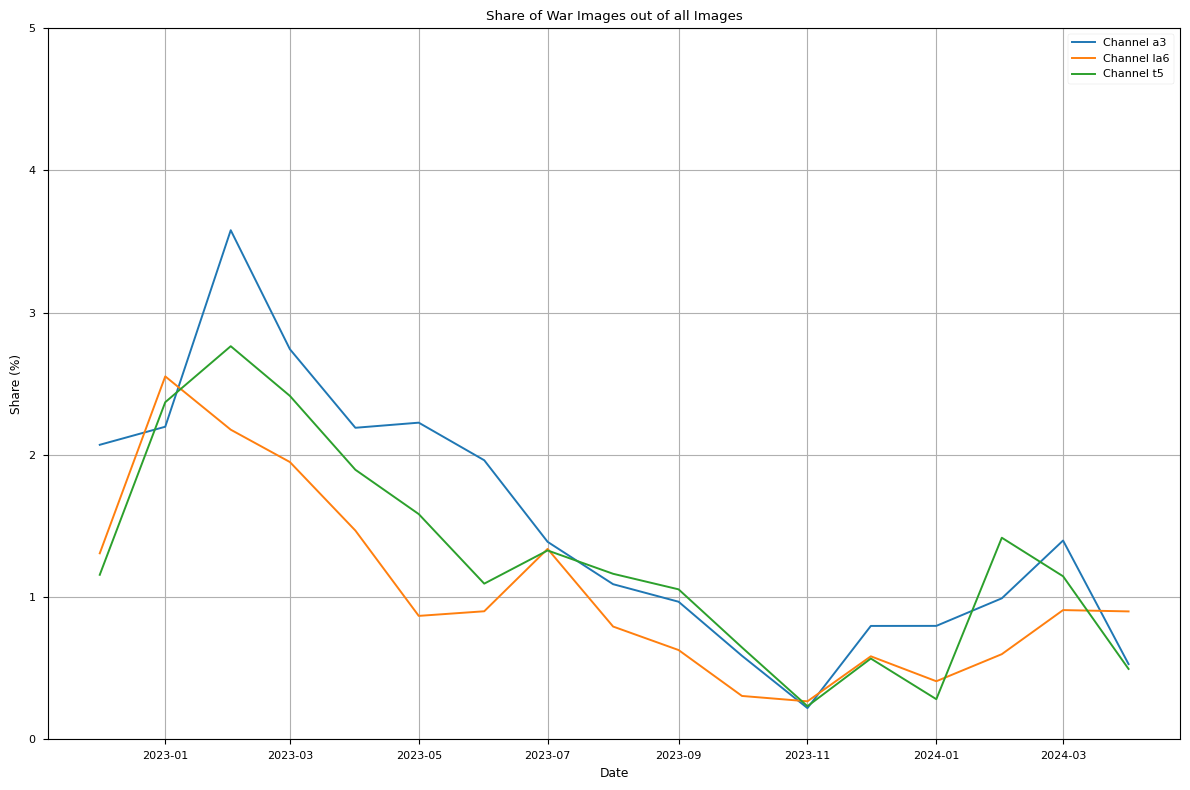

In [52]:
# Plotting
plt.figure(figsize=(12, 8))

channels = war_out_of_total_monthly['channel'].unique()

for channel in channels:
    channel_data = war_out_of_total_monthly[war_out_of_total_monthly['channel'] == channel]
    plt.plot(channel_data['year_month'], channel_data['war_share_out_of_total'] * 100, label=f'Channel {channel}')

plt.title('Share of War Images out of all Images')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

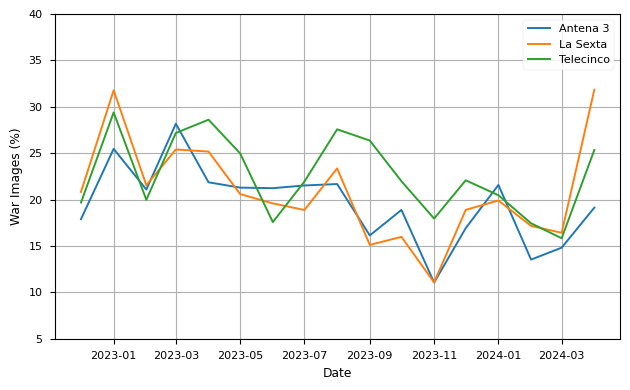

In [53]:
# Share of war images by month and channel

# Plotting
plt.figure(figsize=(6.4, 4))
plt.plot(final_df['year_month'], final_df['a3_share_class_1'] * 100, label=f'Antena 3')
plt.plot(final_df['year_month'], final_df['la6_share_class_1'] * 100, label=f'La Sexta')
plt.plot(final_df['year_month'], final_df['t5_share_class_1'] * 100, label=f'Telecinco')

#plt.title('Share of War Images')
plt.xlabel('Date')
plt.ylabel('War Images (%)')
plt.ylim(5, 40)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(
    'report_charts/war_images_time_trend_no_notes.pdf',
    bbox_inches='tight',
)

plt.show()

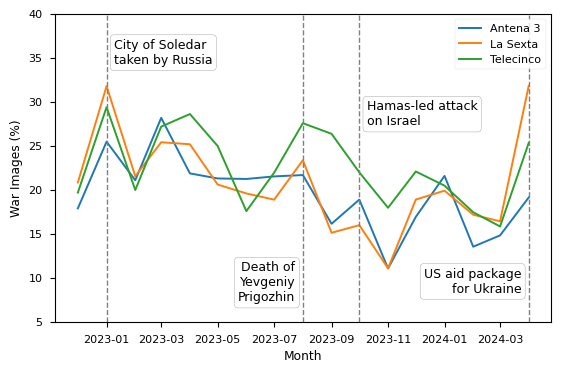

In [54]:
# Share of war images by month and channel with notes

# Plotting
plt.figure(figsize=(6.4, 4))
plt.plot(final_df['year_month'], final_df['a3_share_class_1'] * 100, label=f'Antena 3')
plt.plot(final_df['year_month'], final_df['la6_share_class_1'] * 100, label=f'La Sexta')
plt.plot(final_df['year_month'], final_df['t5_share_class_1'] * 100, label=f'Telecinco')


# Convert the target date to datetime
target_date = pd.to_datetime('2023-01')

# Find the index closest to the target date in the year_month column
idx = final_df['year_month'].sub(target_date).abs().idxmin()

# Vertical line for January 2023
plt.axvline(x=final_df['year_month'].iloc[idx], color='gray', linestyle='--', linewidth=1)

# Annotation with border and background
plt.annotate('City of Soledar\ntaken by Russia',
             xy=(final_df['year_month'].iloc[idx], 33),  # Position of the annotation
             xytext=(final_df['year_month'].iloc[idx] + pd.DateOffset(days=8), 34),  # Position of the text (adjusted a bit to the right)
             va='bottom', ha='left',
             fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white'))  # Box style with border and background


target_date = pd.to_datetime('2023-08')
idx = final_df['year_month'].sub(target_date).abs().idxmin()
plt.axvline(x=final_df['year_month'].iloc[idx], color='gray', linestyle='--', linewidth=1)

# Annotation with border and background
plt.annotate('Death of\nYevgeniy\nPrigozhin',
             xy=(final_df['year_month'].iloc[idx], 33),  # Position of the annotation
             xytext=(final_df['year_month'].iloc[idx] - pd.DateOffset(days=8), 7),  # Position of the text (adjusted a bit to the right)
             va='bottom', ha='right',
             fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white'))  # Box style with border and background


target_date = pd.to_datetime('2023-10')
idx = final_df['year_month'].sub(target_date).abs().idxmin()
plt.axvline(x=final_df['year_month'].iloc[idx], color='gray', linestyle='--', linewidth=1)

# Annotation with border and background
plt.annotate('Hamas-led attack\non Israel',
             xy=(final_df['year_month'].iloc[idx], 33),  # Position of the annotation
             xytext=(final_df['year_month'].iloc[idx] + pd.DateOffset(days=8), 27),  # Position of the text (adjusted a bit to the right)
             va='bottom', ha='left',
             fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white'))  # Box style with border and background


target_date = pd.to_datetime('2024-04')
idx = final_df['year_month'].sub(target_date).abs().idxmin()
plt.axvline(x=final_df['year_month'].iloc[idx], color='gray', linestyle='--', linewidth=1)


# Annotation with border and background
plt.annotate('US aid package\nfor Ukraine',
             xy=(final_df['year_month'].iloc[idx], 33),  # Position of the annotation
             xytext=(final_df['year_month'].iloc[idx] - pd.DateOffset(days=8), 8),  # Position of the text (adjusted a bit to the right)
             va='bottom', ha='right',
             fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white'))  # Box style with border and background




#plt.title('Share of War Images')
plt.xlabel('Month')
plt.ylabel('War Images (%)')
plt.ylim(5, 40)
plt.legend()
# plt.grid(True)
# plt.tight_layout()

plt.savefig(
    'report_charts/war_images_time_trend_notes.pdf',
    bbox_inches='tight',
)

plt.show()

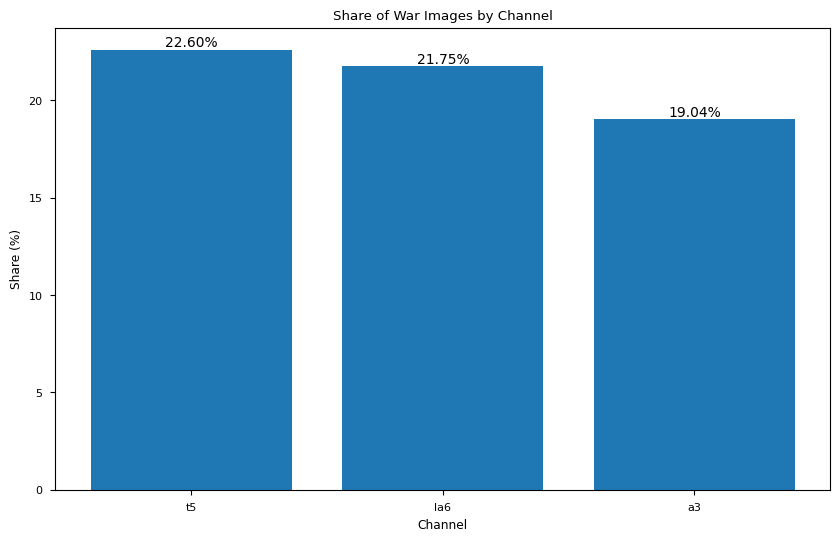

In [55]:
# Share of war images by channel
combined_share_class_1_by_channel = combined_predictions.groupby('channel')['corrected_preds'].mean().reset_index()

# Sort the DataFrame by 'corrected_preds' in descending order
combined_share_class_1_by_channel = combined_share_class_1_by_channel.sort_values(by='corrected_preds', ascending=False)

# Convert 'share_with_ukraine' to percentages
combined_share_class_1_by_channel['corrected_preds'] = combined_share_class_1_by_channel['corrected_preds'] * 100

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(combined_share_class_1_by_channel['channel'], combined_share_class_1_by_channel['corrected_preds'])

# Add labels and title
plt.xlabel('Channel')
plt.ylabel('Share (%)')
plt.title('Share of War Images by Channel')

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}%',
        ha='center',
        va='bottom'
    )

# Display the plot
plt.show()

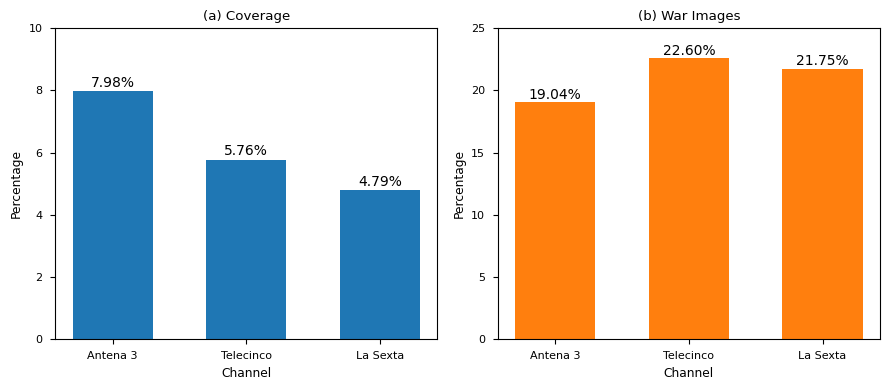

In [56]:
# Data preparation
channels = channel_summary['channel']
combined_share_class_1_by_channel = combined_share_class_1_by_channel.set_index('channel').loc[channels].reset_index()

default_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Number of bars and their width
n = len(channels)
bar_width = 0.6

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Plot the first bar chart on the first subplot
bars1 = ax1.bar(r1, channel_summary['share_with_ukraine'], width=bar_width,  label='Share of Time Speaking about the Russia-Ukraine War')
ax1.set_xlabel('Channel')  #alpha=0.6, color=default_colours[0], 
ax1.set_ylabel('Percentage')
ax1.set_title('(a) Coverage')
ax1.set_xticks(r1)
ax1.set_ylim(0, 10)
ax1.set_xticklabels(['Antena 3', 'Telecinco', 'La Sexta'])

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}%', ha='center', va='bottom')

# Plot the second bar chart on the second subplot
bars2 = ax2.bar(r1, combined_share_class_1_by_channel['corrected_preds'], color=default_colours[1], width=bar_width, label='Share of War Images')
ax2.set_xlabel('Channel')
ax2.set_ylabel('Percentage')
ax2.set_title('(b) War Images')
ax2.set_xticks(r1)
ax2.set_ylim(0, 25)
ax2.set_xticklabels(['Antena 3', 'Telecinco', 'La Sexta'])

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}%', ha='center', va='bottom')

# Adjust layout to make room for the labels
plt.tight_layout()

# Save the figure
plt.savefig('report_charts/static_war_images_cross_channel_separate.pdf', bbox_inches='tight')

# Display the plot
plt.show()


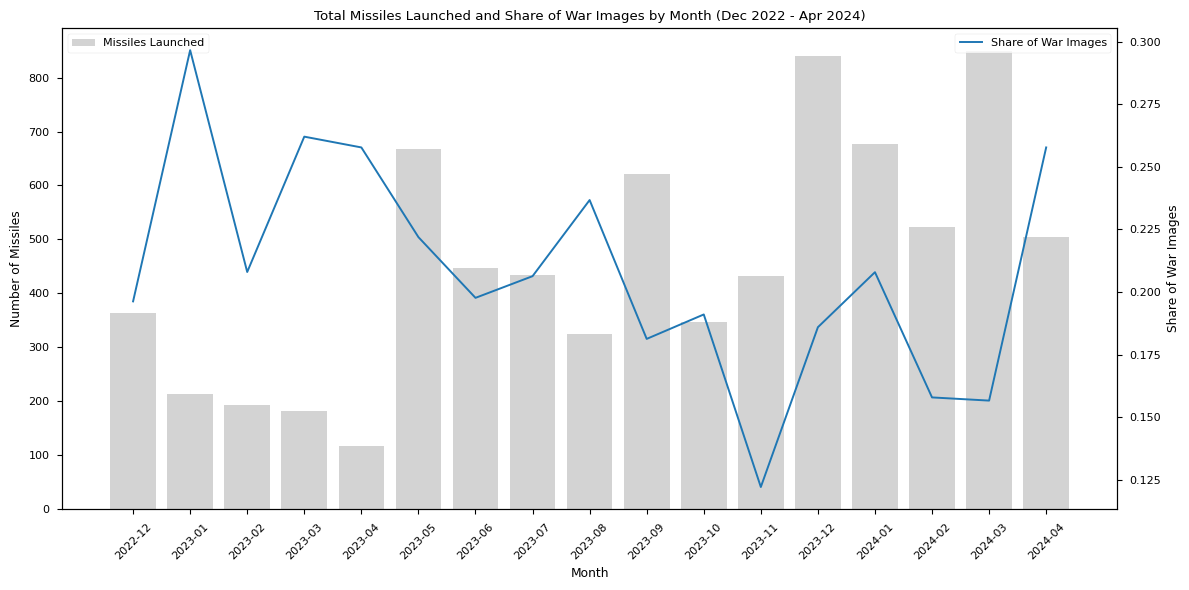

In [57]:
# Num of missiles vs total_share_class_1

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['launched'], color='lightgrey', label='Missiles Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Missiles')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

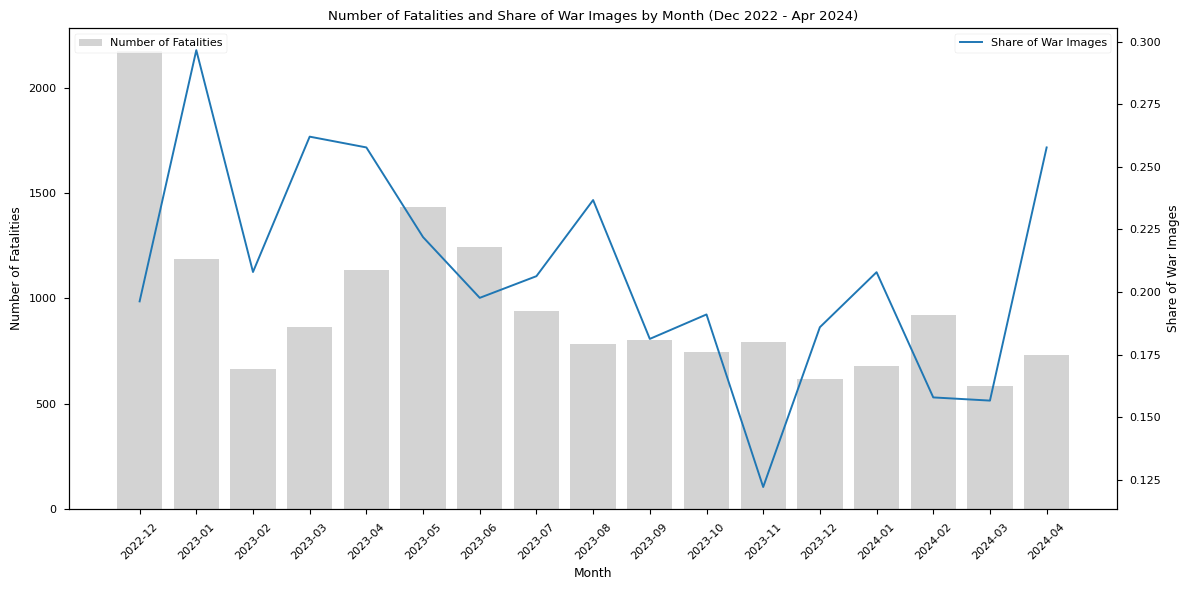

In [58]:
# Num of fatalities vs total_share_class_1

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['fatalities'], color='lightgrey', label='Number of Fatalities')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Fatalities')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')

plt.title('Number of Fatalities and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

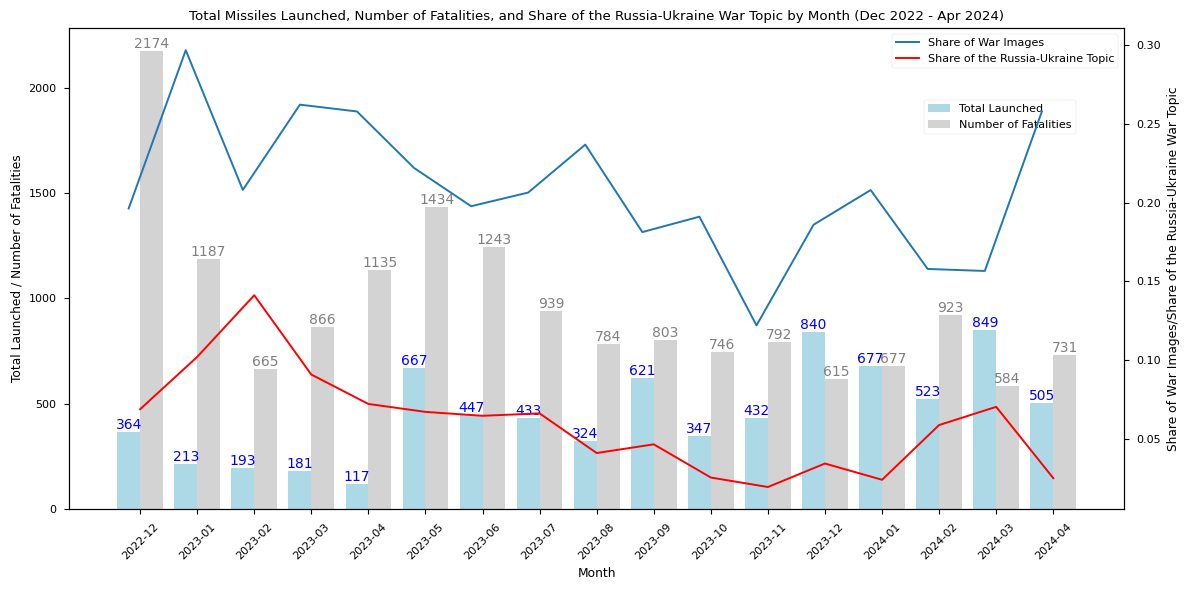

In [59]:
# Plotting number of missles and fatalities together with share of war images and share of coverage of the war

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Plot the second bar chart (Number of Fatalities)
bars2 = ax1.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched / Number of Fatalities')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine'], color='r', label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of War Images/Share of the Russia-Ukraine War Topic')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.81, 0.78))
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()


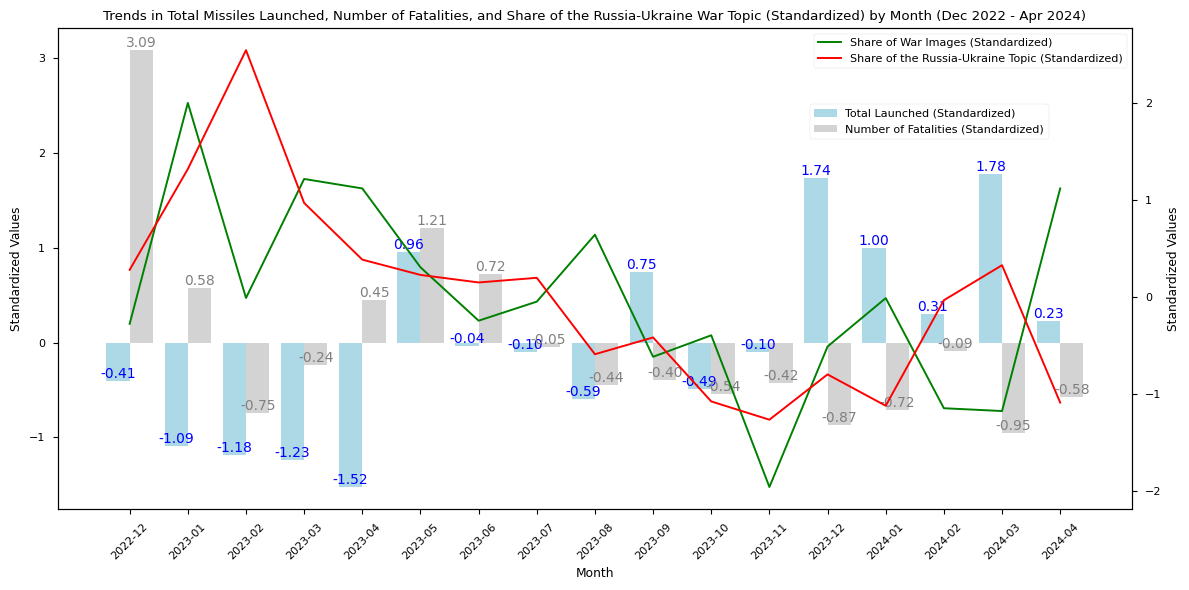

In [60]:
# Plotting standardised values of the above chart to make the trends easier to see

# Standardize the values
df_aggregated['launched_z'] = (df_aggregated['launched'] - df_aggregated['launched'].mean()) / df_aggregated['launched'].std()
df_aggregated['fatalities_z'] = (df_aggregated['fatalities'] - df_aggregated['fatalities'].mean()) / df_aggregated['fatalities'].std()
df_aggregated['share_with_ukraine_z'] = (df_aggregated['share_with_ukraine'] - df_aggregated['share_with_ukraine'].mean()) / df_aggregated['share_with_ukraine'].std()
final_df['total_share_class_1_z'] = (final_df['total_share_class_1'] - final_df['total_share_class_1'].mean()) / final_df['total_share_class_1'].std()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched standardized)
bars1 = ax1.bar(r1, df_aggregated['launched_z'], color='lightblue', width=bar_width, label='Total Launched (Standardized)')

# Plot the second bar chart (Number of Fatalities standardized)
bars2 = ax1.bar(r2, df_aggregated['fatalities_z'], color='lightgrey', width=bar_width, label='Number of Fatalities (Standardized)')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Standardized Values')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(r1 + bar_width / 2, final_df['total_share_class_1_z'], color='g', label='Share of War Images (Standardized)')
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine_z'], color='r', label='Share of the Russia-Ukraine Topic (Standardized)')
ax2.set_ylabel('Standardized Values')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.7, 0.77))
ax2.legend(loc='upper right')

plt.title('Trends in Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic (Standardized) by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

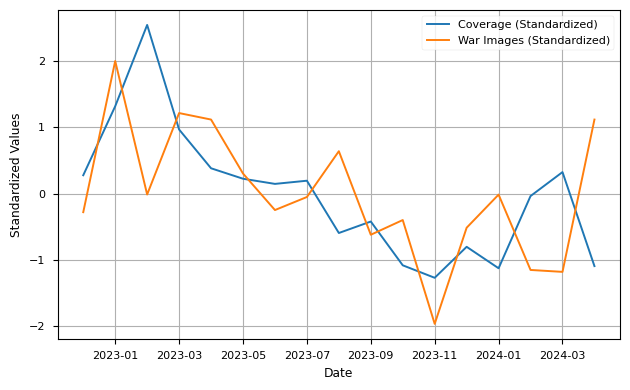

In [61]:
# Plotting
fig, ax1 = plt.subplots(figsize=(6.4, 4))

# Number of points
n = len(df_aggregated)

# Positions on the x-axis
r1 = np.arange(n)

# Plot the line charts
ax1.plot(r1, df_aggregated['share_with_ukraine_z'], label='Coverage (Standardized)')
ax1.plot(r1, final_df['total_share_class_1_z'], label='War Images (Standardized)')

# Add labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Standardized Values')

# Set x-ticks to every other month starting from the second month
every_other_month = r1[1::2]
ax1.set_xticks(every_other_month)
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m')[1::2], ha='center')

# Adding legends
ax1.legend(loc='upper right')

plt.tight_layout()
plt.grid(True)

plt.savefig(
    'report_charts/standardised_time_trends_no_notes.pdf',
    bbox_inches='tight',
)

plt.show()

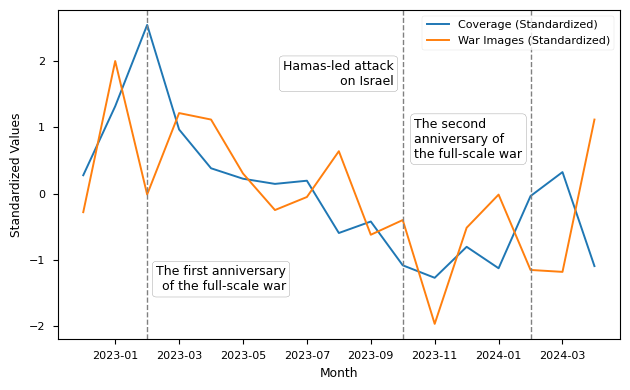

In [62]:
# Plotting
fig, ax1 = plt.subplots(figsize=(6.4, 4))

# Number of points
n = len(df_aggregated)

# Positions on the x-axis
r1 = np.arange(n)

# Plot the line charts
ax1.plot(r1, df_aggregated['share_with_ukraine_z'], label='Coverage (Standardized)')
ax1.plot(r1, final_df['total_share_class_1_z'], label='War Images (Standardized)')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Standardized Values')

# Set x-ticks to every other month starting from the second month
every_other_month = r1[1::2]
ax1.set_xticks(every_other_month)
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m')[1::2], ha='center')

# Adding a vertical line and annotation for 2023-02
date_to_annotate = '2023-02'
# Find the index of the date to annotate
annotate_index = df_aggregated[df_aggregated['year_month'] == date_to_annotate].index[0]
ax1.axvline(x=annotate_index, color='gray', linestyle='--', linewidth=1)
ax1.annotate(
    'The first anniversary\nof the full-scale war', 
    xy=(annotate_index, df_aggregated['share_with_ukraine_z'][annotate_index]), 
    xytext=(df_aggregated['share_with_ukraine_z'][annotate_index]+3.8, -1.5),
    va='bottom', ha='right',
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
)



# Adding a vertical line and annotation for 2023-10
date_to_annotate = '2023-10'
# Find the index of the date to annotate
annotate_index = df_aggregated[df_aggregated['year_month'] == date_to_annotate].index[0]
ax1.axvline(x=annotate_index, color='gray', linestyle='--', linewidth=1)
ax1.annotate(
    'Hamas-led attack\non Israel', 
    xy=(annotate_index, df_aggregated['share_with_ukraine_z'][annotate_index]), 
    xytext=(df_aggregated['share_with_ukraine_z'][annotate_index]+10.8, 1.6),
    va='bottom', ha='right',
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
)


# Adding a vertical line and annotation for 2024-02
date_to_annotate = '2024-02'
# Find the index of the date to annotate
annotate_index = df_aggregated[df_aggregated['year_month'] == date_to_annotate].index[0]
ax1.axvline(x=annotate_index, color='gray', linestyle='--', linewidth=1)
ax1.annotate(
    'The second\nanniversary of\nthe full-scale war', 
    xy=(annotate_index, df_aggregated['share_with_ukraine_z'][annotate_index]), 
    xytext=(df_aggregated['share_with_ukraine_z'][annotate_index]+10.4, 0.5),
    va='bottom', ha='left',
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
)


# Adding legends
ax1.legend(loc='upper right')

plt.tight_layout()
# plt.grid(True)

plt.savefig(
    'report_charts/standardised_time_trends_with_notes.pdf',
    bbox_inches='tight',
)

plt.show()

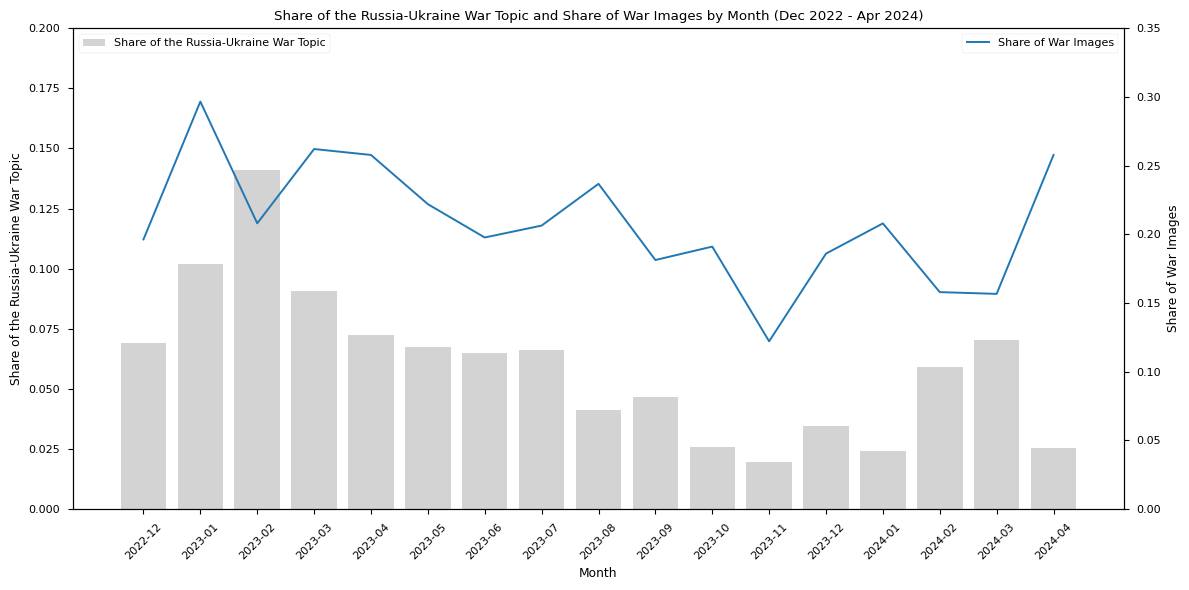

In [63]:
# Share of the Russia-Ukraine war topic vs share_class_1 (total)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()